## 1. Read the data

In [20]:
# Read the data 
import pandas as pd
data_df = pd.read_csv('data/insurance.csv')
data_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 2. Data cleaning

In [21]:
# Check for missing values
data_df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Luckily we have no missing data, proceeding to look at distribution of numerical and categorical features

In [22]:
# check for distribution of numerical features
data_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [23]:
# get summary of categorical features
data_df.describe(include=['O'])

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


The data looks skewed towards non-smokers over smokers.  Proceeding to look at the correlation matrix.

## 3. Plots

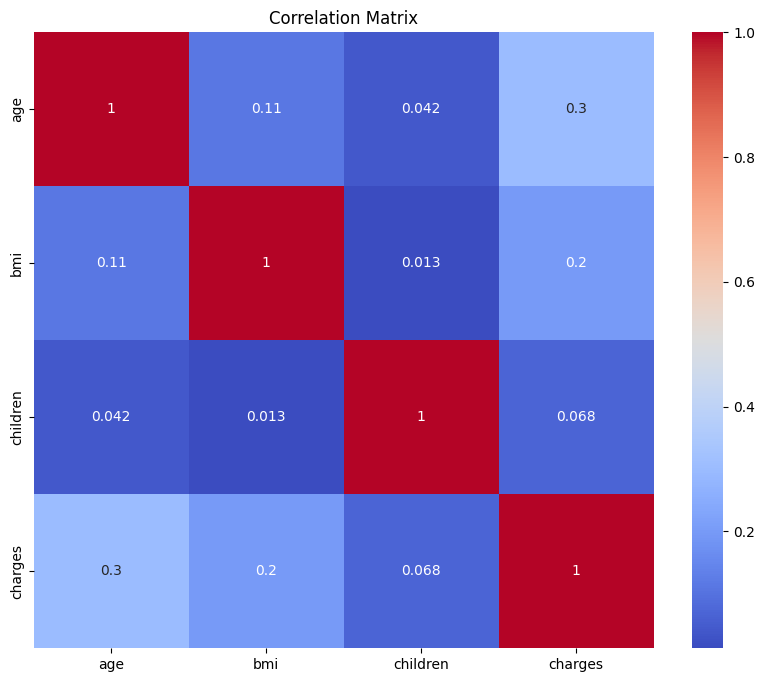

In [24]:
# plot correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
# only numerical features are considered for correlation
numerical_features = data_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data_df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## 5. Simple linear regression as baseline

In [25]:
# model the relationship between charges (y) and the other features (X) using simple linear regression 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Define features and target variable
X = data_df.drop('charges', axis=1)
y = data_df['charges']
# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)
# Use train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use 10 fold cross-validation to evaluate the model
from sklearn.model_selection import cross_val_score
model = LinearRegression()
mse_scores = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print(f'Average MSE from 10-fold CV: {mse_scores.mean()}')
print(f'Average R2 from 10-fold CV: {r2_scores.mean()}')
# Fit the model on the training data
model.fit(X_train, y_train)
# Predict on the test data
y_pred = model.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Test MSE: {mse}')
print(f'Test R2: {r2}')

Average MSE from 10-fold CV: 37885866.061838806
Average R2 from 10-fold CV: 0.7297411102077808
Test MSE: 33596915.85136146
Test R2: 0.7835929767120723


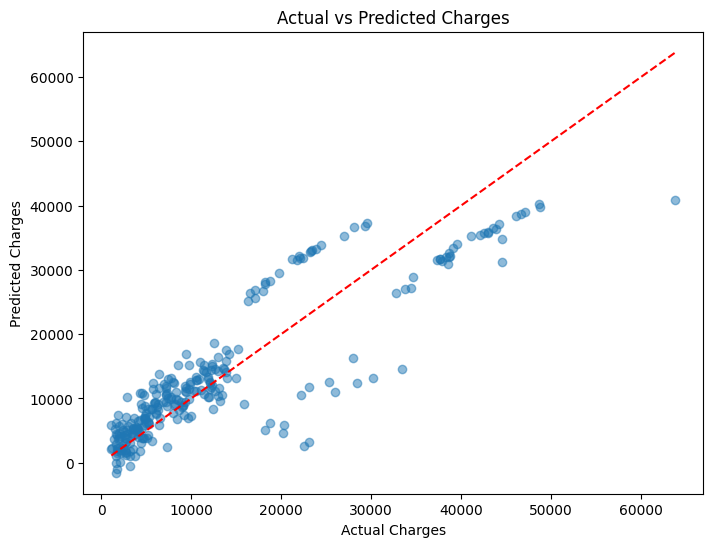

In [26]:
# make a scatter plot of model predicted charges vs actual charges
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()

Now that we have a baseline, we can explore more complex models and feature engineering techniques to improve performance.

## 6. Using Lasso for feature selection to then narrow down the model to relevant attributes

In [27]:
# Run Lasso for feature selection
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.5)
lasso.fit(X_train, y_train)
# Get the coefficients
lasso_coefficients = pd.Series(lasso.coef_, index=X.columns)
# Select features with non-zero coefficients
selected_features = lasso_coefficients[lasso_coefficients != 0].index
print("Selected features by Lasso:")
print(selected_features)

Selected features by Lasso:
Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')


Lasso has retained all attributes

In [28]:
# using the lasso coefficients, print the importance of each feature
import numpy as np
importance = np.abs(lasso.coef_)
feature_importance = pd.Series(importance, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)
print("Feature importance based on Lasso coefficients:")
print(feature_importance)

Feature importance based on Lasso coefficients:
smoker_yes          23647.950696
region_southwest      801.613222
region_southeast      649.389225
children              424.928902
region_northwest      362.593319
bmi                   336.981027
age                   256.971845
sex_male               16.332119
dtype: float64


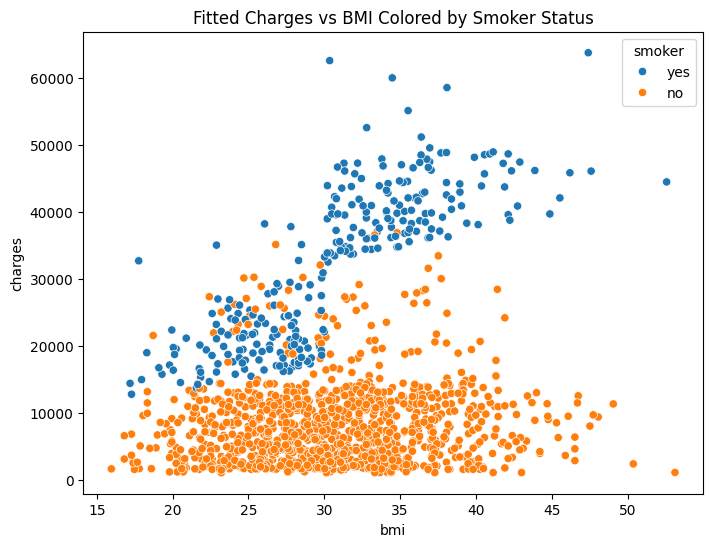

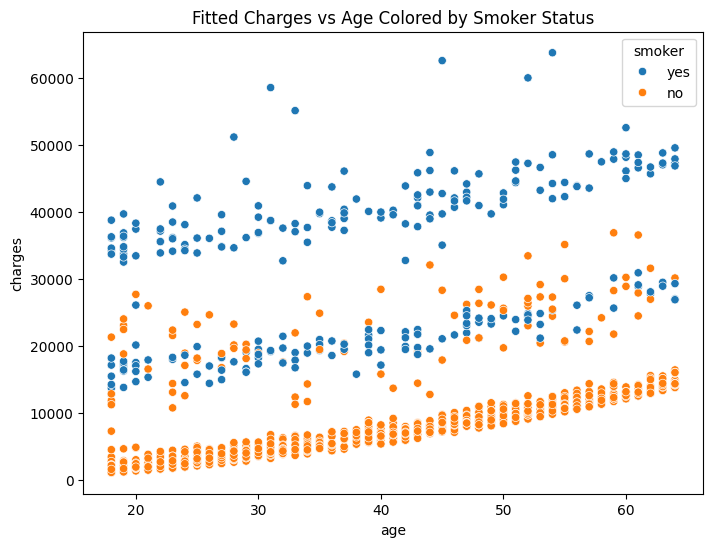

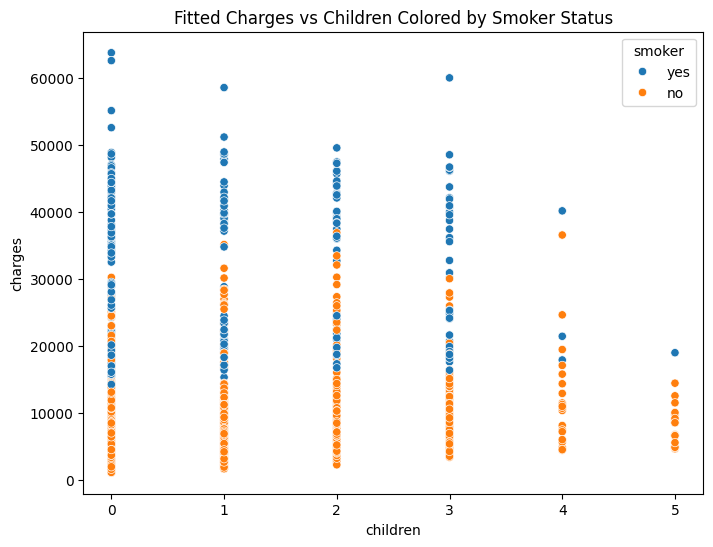

In [29]:
# Since smoker is the most important feature, plot a scatter plot of fitted charges vs each numerical feature colored by smoker status
plt.figure(figsize=(8, 6))
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=data_df)
plt.title('Fitted Charges vs BMI Colored by Smoker Status')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='age', y='charges', hue='smoker', data=data_df)
plt.title('Fitted Charges vs Age Colored by Smoker Status')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='children', y='charges', hue='smoker', data=data_df)
plt.title('Fitted Charges vs Children Colored by Smoker Status')
plt.show()

From plot of fitted charges vs bmi, we see a spike in charges for smokers with bmi>30, so considering a split in this group as a new feature and adding an interaction term between the new feature and smoker in the new model

In [33]:
# From plot of fitted charges vs bmi, we see a spike in charges for smokers with bmi>30, 
# so considering a split in this group as a new feature and 
# adding an interaction term between the new feature and smoker in the new model   
data_df['high_bmi_smoker'] = ((data_df['bmi'] > 30) & (data_df['smoker'] == 'yes')).astype(int)
# Re-define features and target variable with the new feature
X = data_df.drop('charges', axis=1)
y = data_df['charges']
# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)
# Use train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Use 10 fold cross-validation to evaluate the new model
model = LinearRegression()
mse_scores = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print(f'Average MSE from 10-fold CV after adding high_bmi_smoker feature: {mse_scores.mean()}')
print(f'Average R2 from 10-fold CV after adding high_bmi_smoker feature: {r2_scores.mean()}')
# Fit the new model on the training data
model.fit(X_train, y_train)
# Predict on the test data
y_pred = model.predict(X_test)
# Evaluate the new model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Test MSE after adding high_bmi_smoker feature: {mse}')
print(f'Test R2 after adding high_bmi_smoker feature: {r2}')

Average MSE from 10-fold CV after adding high_bmi_smoker feature: 20407886.608906474
Average R2 from 10-fold CV after adding high_bmi_smoker feature: 0.8538495787400759
Test MSE after adding high_bmi_smoker feature: 18590528.195496622
Test R2 after adding high_bmi_smoker feature: 0.8802532683078205


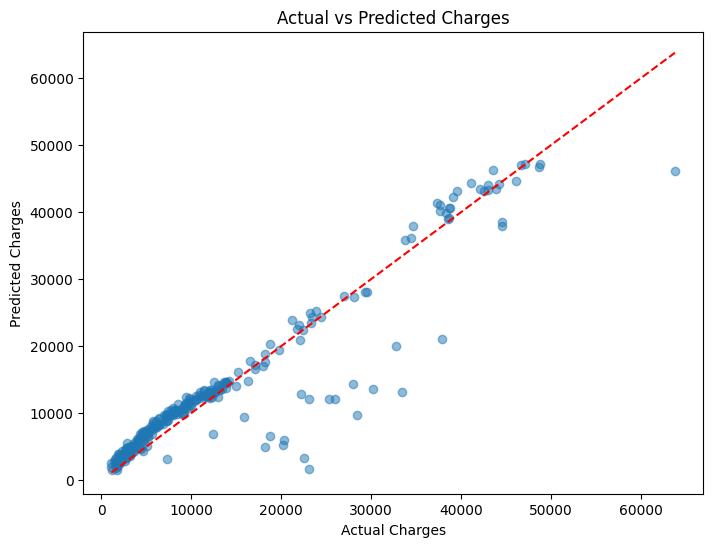

In [34]:
# make a scatter plot of model predicted charges vs actual charges
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()

We have a better fit now with the inclusion of the new feature, our test R2 has gone up from 0.7835929767120723 to 0.8802532683078205

In [35]:
# Try using a Random Forest with hyperparameter tuning to see if we can improve the model performance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
# Predict on the test data using the best Random Forest model
y_pred_rf = best_rf.predict(X_test)
# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest Test MSE: {mse_rf}')
print(f'Random Forest Test R2: {r2_rf}')

Random Forest Test MSE: 18925226.91345442
Random Forest Test R2: 0.8780973813337904


In [ ]:
# use LightGBM to see if we can improve the model performance further
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
# specify your configurations as a dict
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_eval)
# predict
y_pred_lgb = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# evaluate
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)
print(f'LightGBM Test MSE: {mse_lgb}')
print(f'LightGBM Test R2: {r2_lgb}')

TypeError: train() got an unexpected keyword argument 'early_stopping_rounds'